*ChatGPT-4 used throughout to generate code snippets*

# Setup

## Install libraries

geopandas, fastparquet, numpy

In [1]:
# in jupyter notebooks, normal install using !pip install doesn't work, use the solution from:
# https://www.geeksforgeeks.org/install-python-package-using-jupyter-notebook/

import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install fastparquet
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install tempun

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet
import tempun

## Import LIRE_v2.3 dataset 

**Source**: https://zenodo.org/record/8147298

**Format**: parquet

In [3]:
lire = gpd.read_parquet('data/LIRE_v2-3.parquet')

### Display first five rows of LIRE dataset

In [4]:
lire.head(5)

,LIST-ID,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,...,not_before,Longitude,Latitude,geotemporal?,geometry,urban_context,urban_context_city,urban_context_pop_est,type_of_inscription_auto,type_of_inscription_auto_prob
445464,445465,EDCS-03700724,HD052964,https://www.trismegistos.org/text/121715,531064,Fortissimo et piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et piissimo Caesari domino nostro G...,...,309.0,20.766800,39.451200,True,POINT (20.767 39.451),rural,None,NaN,honorific inscription,1.0
445466,445467,EDCS-03300852,HD051000,https://www.trismegistos.org/text/177273,240855,[Imp(eratori) Caes(ari) M(arco)] / An[nio] Flo...,Imp(eratori) / Floriano / P(io) F(elici) Aug(u...,An Floriano P F Aug p p m p III Imp Caes M Aur...,Imperatori Caesari Marco Annio Floriano Pio Fe...,Imperatori Caesari Marco Annio Floriano Pio Fe...,...,276.0,22.417100,37.431900,True,POINT (22.417 37.432),large,Tegea,46362.0,mile-/leaguestone,1.0
445467,445468,EDCS-28500283,HD021396,https://www.trismegistos.org/text/177131,,T[i(berius)] Claudius Caesar Aug(ustus) / G[er...,T[(iberius)] Claudius Caesar Aug(ustus) / G[er...,T Claudius Caesar Aug Ganicus pontif max trib ...,Tiberius Claudius Caesar Augustus Germanicus p...,Tiberius Claudius Caesar Augustus Germanicus p...,...,49.0,22.420877,37.454501,True,POINT (22.421 37.455),large,Tegea,46362.0,public legal inscription,1.0
445469,445470,EDCS-09400671,HD011892,https://www.trismegistos.org/text/177087,,Pro salute Imp(eratorum) Caesari(s) / L(uci) S...,Pro salute Imp(eratoris) Caesari(s) / L(uci) S...,Pro salute Imp Caesari L Septimi Severi et M A...,Pro salute Imperatorum Caesaris Luci Septimi S...,Pro salute Imperatorum Caesaris Luci Septimi S...,...,198.0,24.937637,37.837612,True,POINT (24.938 37.838),rural,None,NaN,votive inscription,1.0
445471,445472,EDCS-24600769,HD050999,https://www.trismegistos.org/text/177272,570531,Octa(vius) Sal(utaris),Octa(vius) Sa(lutaris),Octa Sal,Octavius Salutaris,Octavius Salutaris,...,81.0,21.627100,37.647900,True,POINT (21.627 37.648),rural,None,NaN,owner/artist inscription,1.0


### Print column names

Also set column names as a variable so that it can be used later

In [5]:
lire_columns = lire.columns
print("\n".join(lire_columns))

LIST-ID
EDCS-ID
EDH-ID
trismegistos_uri
pleiades_id
transcription
inscription
clean_text_conservative
clean_text_interpretive_sentence
clean_text_interpretive_word
clean_text_interpretive_word_EDCS
diplomatic_text
province
place
inscr_type
status_notation
inscr_process
status
partner_link
last_update
letter_size
type_of_inscription
work_status
year_of_find
present_location
text_edition
support_objecttype
support_material
support_decoration
keywords_term
people
type_of_inscription_clean
type_of_inscription_certainty
height_cm
width_cm
depth_cm
material_clean
type_of_monument_clean
type_of_monument_certainty
province_label_clean
province_label_certainty
country_clean
country_certainty
findspot_ancient_clean
findspot_ancient_certainty
modern_region_clean
modern_region_certainty
findspot_modern_clean
findspot_modern_certainty
findspot_clean
findspot_certainty
language
language_EDCS
raw_dating
not_after
not_before
Longitude
Latitude
geotemporal?
geometry
urban_context
urban_context_city
urb

# Clean data

The quality of the dataset is pretty good, but I found some errors where the date range is negative. Vojtech suggests reversing the dates.

Find rows where 'not_before' is greater than 'not_after'

In [6]:
error_rows = lire[lire['not_before'] > lire['not_after']]

Swap the 'not_before' and 'not_after' values

In [7]:
# Define a function to swap 'not_before' and 'not_after' when 'not_before' > 'not_after'
def swap_dates(row):
    if row['not_before'] > row['not_after']:
        row['not_before'], row['not_after'] = row['not_after'], row['not_before']
    return row

# Apply the function to swap the dates
lire = lire.apply(swap_dates, axis=1)

# Overview: SPA of the entire LIRE dataset

## All inscriptions, uniform distribution between start and end dates, disregard locations

Define the resolution for the summed probability distribution

*Resolution must be defined because this dataset is formatted 'float' and not 'interger'. Resolution defines the size of bins or segments in years*.

In [8]:
resolution = 10

Initialize the summed probability distribution

In [9]:
earliest_date = lire['not_before'].min()
latest_date = lire['not_after'].max()

Creat an array of zeros to hold the summed probabilities

In [10]:
num_bins = int((latest_date - earliest_date) / resolution) + 1
summed_prob = np.zeros(num_bins)

Loop through each inscription to update the summed probability distribution


In [11]:
for index, row in lire.iterrows():
    start = row['not_before']
    end = row['not_after']
    
    start_idx = int((start - earliest_date) / resolution)
    end_idx = int((end - earliest_date) / resolution)
   
    # Calculate uniform distribution for this inscription,
    # accounting for date combinations that add up to zero
    try:
        uniform_prob = 1.0 / (end_idx - start_idx + 1)
    except ZeroDivisionError:
        uniform_prob = 1  # set default value here

    # Add this distribution to the overall summed distribution
    summed_prob[start_idx : end_idx + 1] += uniform_prob

Plot the summed probability distribution

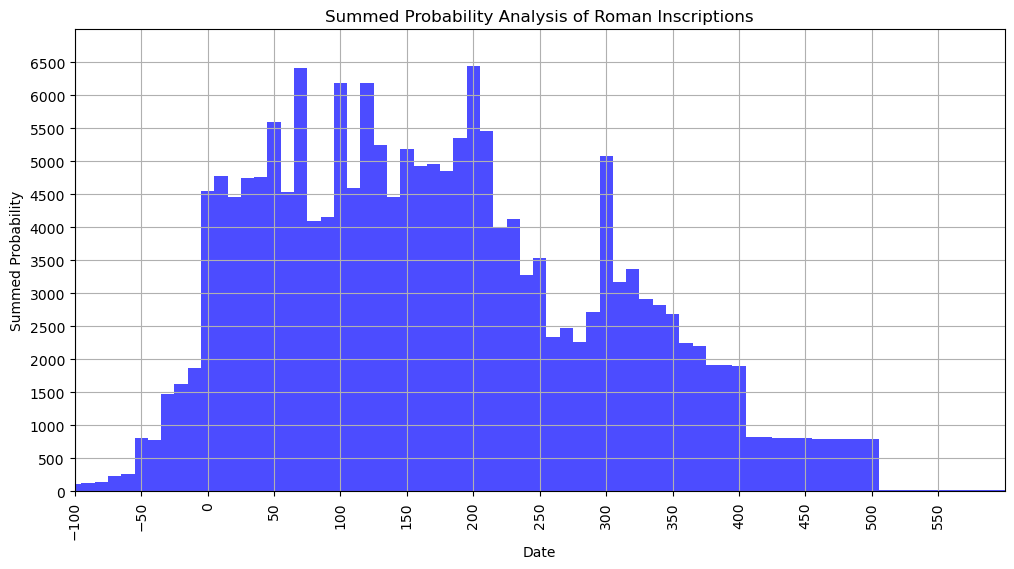

In [12]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(np.arange(earliest_date, latest_date + resolution, resolution), summed_prob, width=resolution, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Summed Probability')
plt.title('Summed Probability Analysis of Roman Inscriptions')

# set axis limits and grid
plt.xlim([-100, 600])
plt.ylim([0, 7000])
plt.grid(True)
plt.xticks(np.arange(-100, 600, 50), rotation='vertical')  # Change 10 to the desired tick interval for the x-axis
plt.yticks(np.arange(0, 7000, 500))  # Change 500 to the desired tick interval for the y-axis

# Show the plot
plt.show()

Looking at this overview plot:

* Several of the peaks seem to correspond to dynasty changes.
* Start date should probably be 1 AD
* End date should probably be 400 AD

# Understanding uncertainty: date range statistics

Calculate date range for each inscription and add it to the DF

In [13]:
lire['date_range'] = lire['not_after'] - lire['not_before']

### Calculate descriptive statistics

In [14]:
# Return the total number of records

total_records = lire.shape[0]

# Calculate the average date range
average_range = lire['date_range'].mean()

# Calculate the median date range
median_range = lire['date_range'].median()

# Calculate the standard deviation of the date range
std_dev_range = lire['date_range'].std()

print(f"Total number of records: {total_records}")
print(f"Average Date Range: {average_range}")
print(f"Median Date Range: {median_range}")
print(f"Standard Deviation of Date Range: {std_dev_range}")

Total number of records: 182852
Average Date Range: 101.28705182333253
Median Date Range: 99.0
Standard Deviation of Date Range: 76.75115026800985


### Create a histogram of date ranges

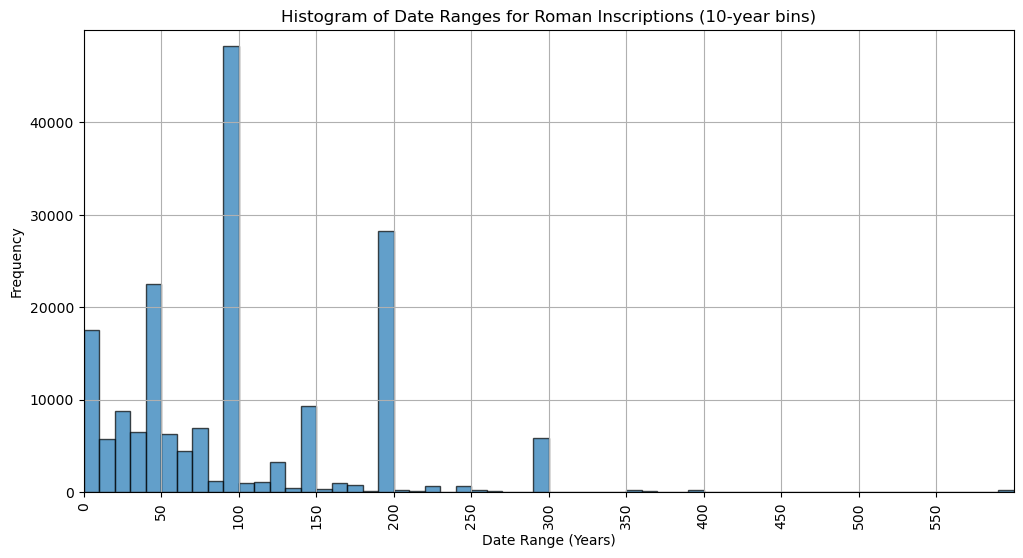

In [15]:
# Create the histogram
plt.figure(figsize=(12, 6))
plt.hist(lire['date_range'], bins=np.arange(0, lire['date_range'].max() + 10, 10), edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Date Range (Years)')
plt.ylabel('Frequency')
plt.title('Histogram of Date Ranges for Roman Inscriptions (10-year bins)')

# set axis limits and grid
plt.xlim([0, 600])
plt.ylim([0, 50000])
plt.grid(True)
plt.xticks(np.arange(0, 600, 50), rotation='vertical')  # Change 10 to the desired tick interval for the x-axis
plt.yticks(np.arange(0, 50000, 10000))  # Change 500 to the desired tick interval for the y-axis

# Show the plot
plt.show()

### Count number of inscriptions *between* various date-range thresholds

300, 200, 100, 50, 25, 10, and 1 year / exact date thresholds

In [16]:
# Define the thresholds

thresholds = [1, 10, 25, 50, 100, 200, 300] 

# Create bins using the thresholds
bins = [0] + thresholds + [lire['date_range'].max() + 1]

# Categorize the date ranges based on the bins
lire['date_range_bins'] = pd.cut(lire['date_range'], bins, right=False) # Count is right-exclusive

# Count the number of inscriptions in each bin
inscription_counts = lire['date_range_bins'].value_counts().sort_index()

# Display the counts
print("Counts of inscriptions with date ranges between certain thresholds:")
print(inscription_counts)

# As a check, count the number of inscriptions with a '0' date range 
# (date reanges should not be less that one year)

print("Specific counts for cross-checking")
zero_date_range_count = len(lire[lire['date_range'] == 0])
print(f"Number of records with a date range of 0: {zero_date_range_count}")
lessthanone_date_range_count = len(lire[lire['date_range'] < 1])
print(f"Number of records with a date range of < 1: {lessthanone_date_range_count}")
oneorless_date_range_count = len(lire[lire['date_range'] <= 1])
print(f"Number of records with a date range of <= 1: {oneorless_date_range_count}")
lessthanzero_date_range_count = len(lire[lire['date_range'] < 0])
print(f"Number of records with a date range less than 0: {lessthanzero_date_range_count}")


Counts of inscriptions with date ranges between certain thresholds:
[0.0, 1.0)          8279
[1.0, 10.0)         9296
[10.0, 25.0)        8415
[25.0, 50.0)       35122
[50.0, 100.0)      67162
[100.0, 200.0)     45651
[200.0, 300.0)      7995
[300.0, 2060.0)      932
Name: date_range_bins, dtype: int64
Specific counts for cross-checking
Number of records with a date range of 0: 8279
Number of records with a date range of < 1: 8279
Number of records with a date range of <= 1: 11069
Number of records with a date range less than 0: 0


### Identify records with a date range less than zero

#### *Records have now been cleaned above to resolve the problem of negative date ranges*.

In [17]:
# Filter records where date_range is less than 0
records_with_negative_date_range = lire[lire['date_range'] < 0]

# Display only specific columns for the filtered records
print(records_with_negative_date_range[['LIST-ID', 'raw_dating', 'not_before', 'not_after', 'date_range']])

records_with_negative_date_range.to_csv("records_with_negative_date_range", index=False)

Empty DataFrame
Columns: [LIST-ID, raw_dating, not_before, not_after, date_range]
Index: []


### Count number of inscriptions with date ranges *under* various thresholds

In [18]:
# Define the thresholds
thresholds = [1, 10, 25, 50, 100, 200, 300]

# Initialize an empty dictionary to store counts
cumulative_counts = {}

# Calculate counts for each threshold
for threshold in thresholds:
    count = len(lire[lire['date_range'] < threshold]) # counts are right-exclusive
    cumulative_counts[threshold] = count

# Display the counts
print("Cumulative counts of inscriptions with date ranges under various thresholds:")
for threshold, count in cumulative_counts.items():
    print(f"0-{threshold} years: {count}")

Cumulative counts of inscriptions with date ranges under various thresholds:
0-1 years: 8279
0-10 years: 17575
0-25 years: 25990
0-50 years: 61112
0-100 years: 128274
0-200 years: 173925
0-300 years: 181920


# SPA on subsets of data with narrower date ranges

## 100 years or less (trial)

Filter dataset to include only inscriptions with a date range of 100 years or less

In [19]:
filtered_lire = lire[lire['date_range'] <= 100]

Run the SPA as above, but on the filtered dataset

In [20]:
# Define the resolution for the summed probability distribution
resolution = 10

# Initialize the summed probability distribution
earliest_date = filtered_lire['not_before'].min()
latest_date = filtered_lire['not_after'].max()

# Create an array of zeros to hold the summed probabilities
num_bins = int((latest_date - earliest_date) / resolution) + 1
summed_prob = np.zeros(num_bins)

# Loop through each inscription to update the summed probability distribution
for index, row in filtered_lire.iterrows():
    start = row['not_before']
    end = row['not_after']
    
    start_idx = int((start - earliest_date) / resolution)
    end_idx = int((end - earliest_date) / resolution)
    
    # Handle the zero-division case
    try:
        uniform_prob = 1.0 / (end_idx - start_idx + 1)
    except ZeroDivisionError:
        uniform_prob = 1  # or another default value

    # Add this distribution to the overall summed distribution
    summed_prob[start_idx : end_idx + 1] += uniform_prob


Plot the summed probability distribution

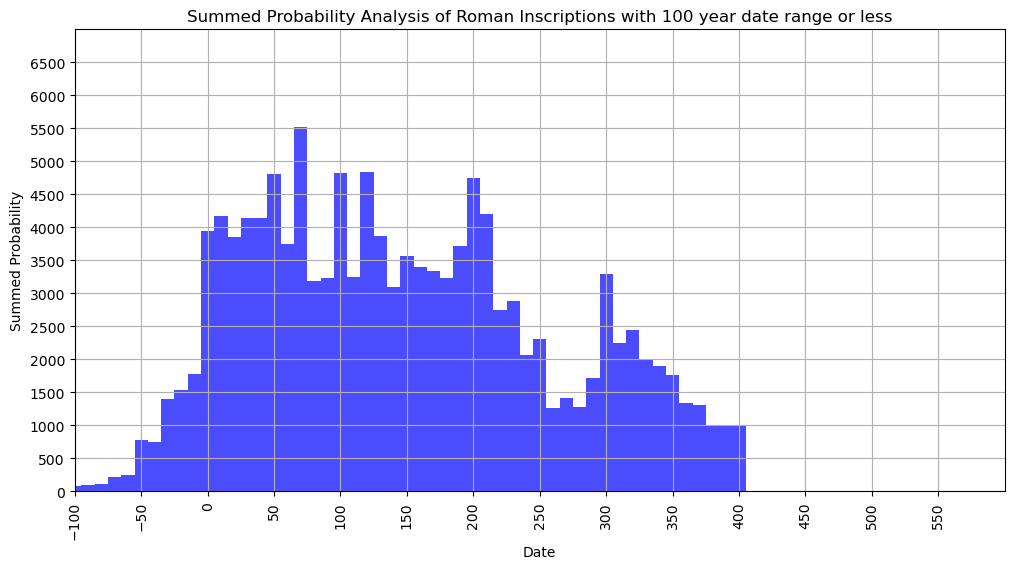

In [21]:
# Recalculate x_values to match summed_prob to avoid a ValueError: shape mismatch between them
x_values = np.arange(earliest_date, earliest_date + resolution*num_bins, resolution)

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Summed Probability')
plt.title('Summed Probability Analysis of Roman Inscriptions with 100 year date range or less')

# set axis limits and grid
plt.xlim([-100, 600])
plt.ylim([0, 7000])
plt.grid(True)
plt.xticks(np.arange(-100, 600, 50), rotation='vertical')  # Change 10 to the desired tick interval for the x-axis
plt.yticks(np.arange(0, 7000, 500))  # Change 500 to the desired tick interval for the y-axis

# Show the plot
plt.show()

## SPA *between* various thresholds

0-1; 1-10; 10-25; 25-50; 50-100; 100-200; 200-300 right exclusive

Compute summed probability distribution

In [48]:
def compute_summed_probability(df, earliest_date, latest_date, resolution=25):  # Changed from 10 to 25
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)

    for _, row in df.iterrows():
        start_idx = int((row['not_before'] - earliest_date) / resolution)
        end_idx = int((row['not_after'] - earliest_date) / resolution)

        # Skip if start_idx or end_idx is out of range
        if start_idx >= num_bins or end_idx < 0:
            continue

        # Clip indices to be within valid range
        start_idx = max(start_idx, 0)
        end_idx = min(end_idx, num_bins - 1)

        # Calculate uniform probability for the date range
        if end_idx - start_idx > 0:
            uniform_prob = 1.0 / (end_idx - start_idx + 1)
        else:
            uniform_prob = 1.0

        summed_prob[start_idx:end_idx + 1] += uniform_prob

    return summed_prob


Define thresholds for date ranges and create plots

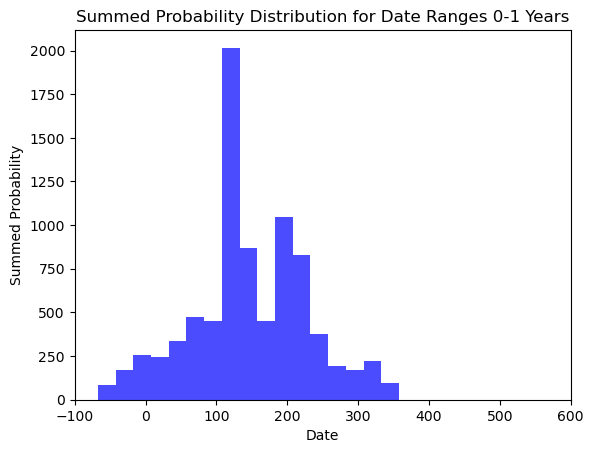

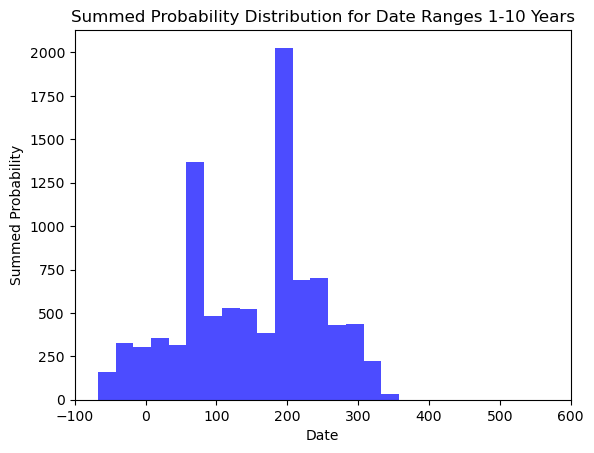

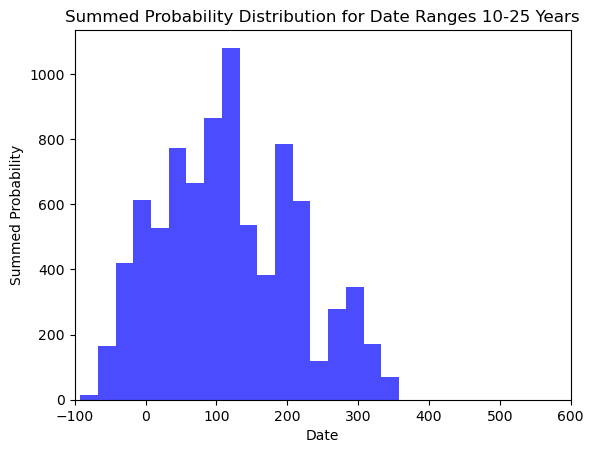

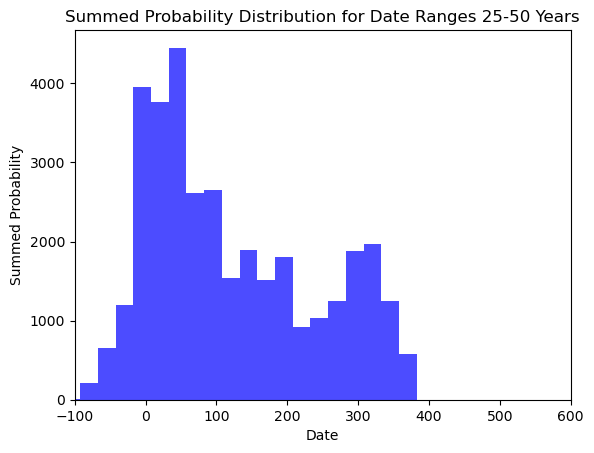

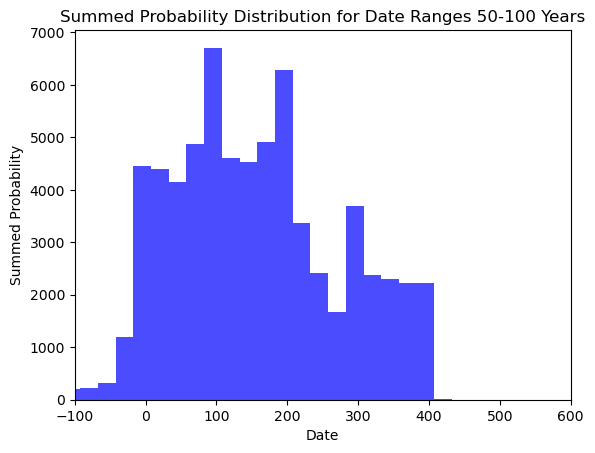

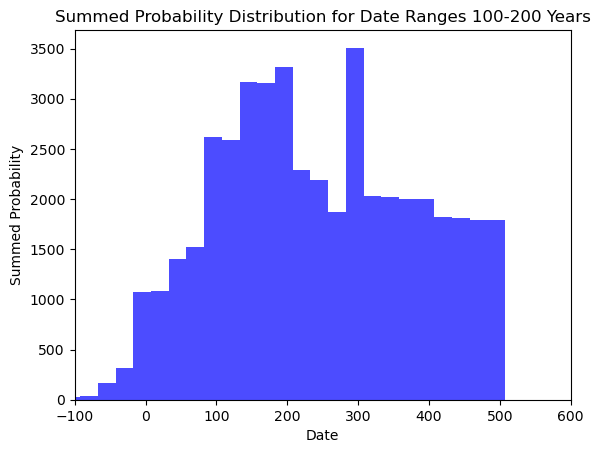

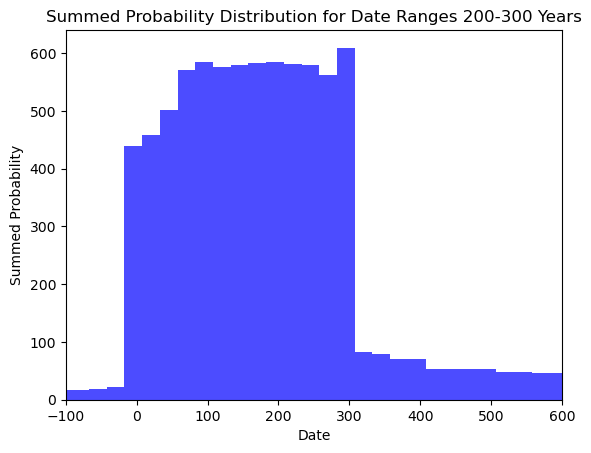

In [50]:
# Create a column for date ranges
lire['date_range'] = lire['not_after'] - lire['not_before']

# Define date range thresholds
thresholds = [
    (0, 1),
    (1, 10),
    (10, 25),
    (25, 50),
    (50, 100),
    (100, 200),
    (200, 300),
]

# Determine the earliest and latest dates for the axis
earliest_date = int(lire['not_before'].min())
latest_date = int(lire['not_after'].max())

# Create a plot for each threshold
for start, end in thresholds:
    subset_df = lire[(lire['date_range'] >= start) & (lire['date_range'] < end)]
    
    # Set the resolution to 25 years
    summed_prob = compute_summed_probability(subset_df, earliest_date, latest_date, resolution=25)  

    plt.figure()
    plt.title(f'Summed Probability Distribution for Date Ranges {start}-{end} Years')
    
    # Changed width and step size in np.arange to 25
    plt.bar(np.arange(earliest_date, latest_date, 25), summed_prob, width=25, color='blue', alpha=0.7)  
    plt.xlim([-100, 600])
    plt.xlabel('Date')
    plt.ylabel('Summed Probability')
    plt.show()

### SPA for dates *below* certain thresholds

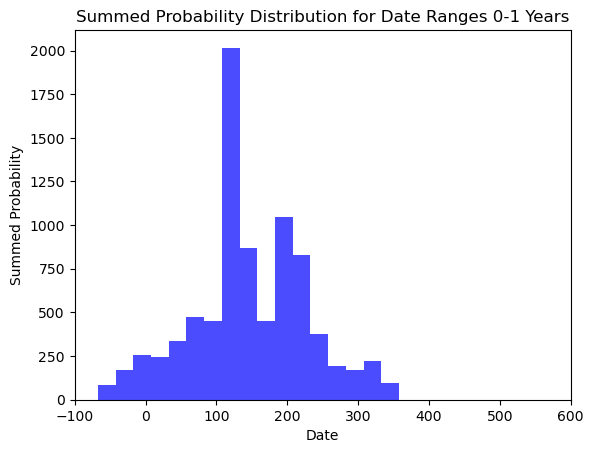

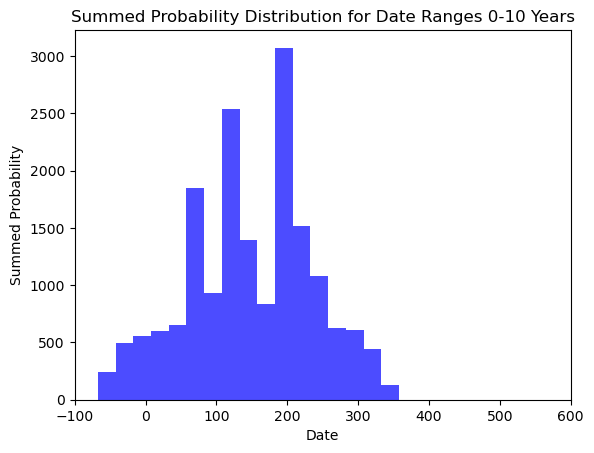

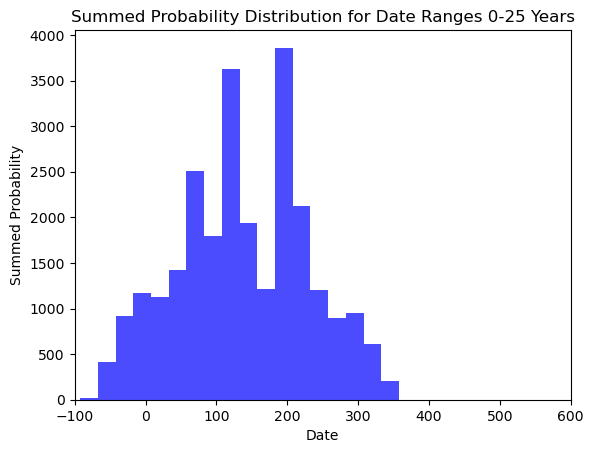

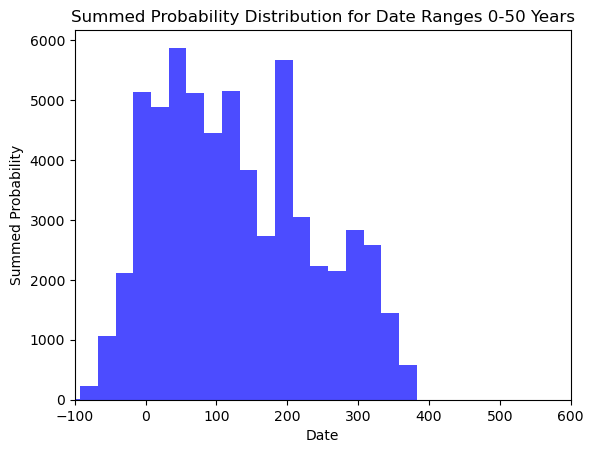

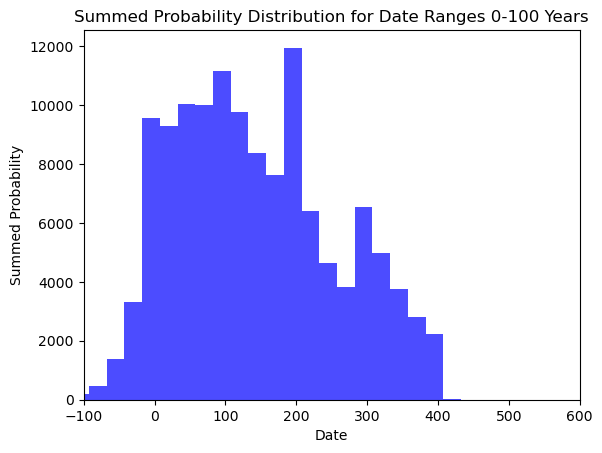

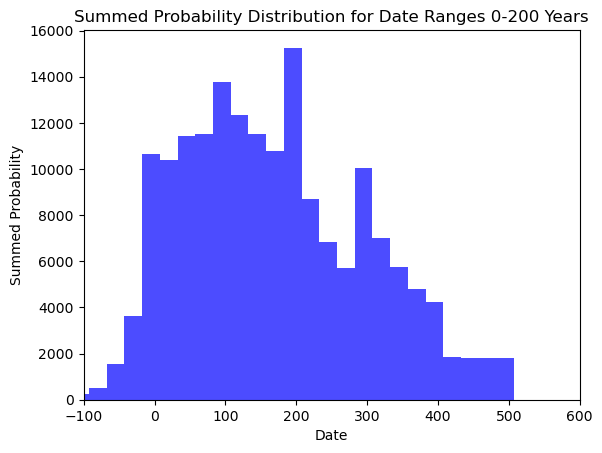

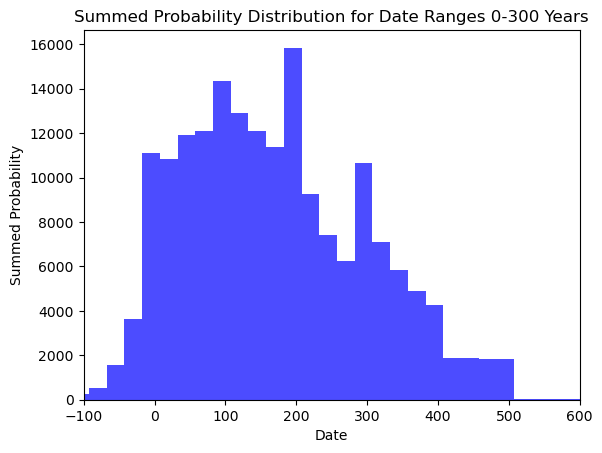

In [52]:
# Create a column for date ranges
lire['date_range'] = lire['not_after'] - lire['not_before']

# Define date range thresholds
thresholds = [
    (0, 1),
    (0, 10),
    (0, 25),
    (0, 50),
    (0, 100),
    (0, 200),
    (0, 300),
]

# Determine the earliest and latest dates for the axis
earliest_date = int(lire['not_before'].min())
latest_date = int(lire['not_after'].max())
remainder = (latest_date - earliest_date) % 25
latest_date_adjusted = latest_date + (25 - remainder)


# Create a plot for each threshold
for start, end in thresholds:
    subset_df = lire[(lire['date_range'] >= start) & (lire['date_range'] < end)]
    
    # Set the resolution to 25 years
    summed_prob = compute_summed_probability(subset_df, earliest_date, latest_date_adjusted, resolution=25)  

    plt.figure()
    plt.title(f'Summed Probability Distribution for Date Ranges {start}-{end} Years')
    
    # Changed width and step size in np.arange to 25
    plt.bar(np.arange(earliest_date, latest_date_adjusted, 25), summed_prob, width=25, color='blue', alpha=0.7)  
    plt.xlim([-100, 600])
    plt.xlabel('Date')
    plt.ylabel('Summed Probability')
    plt.show()

## SPA *between* various thresholds with error margins

Error bars indicate standard deviation for each bin

### Compute summed probability and error

In [58]:
def compute_summed_probability(df, earliest_date, latest_date, resolution=10):
    """Calculate summed probability distribution.
    
    Parameters:
    - df: DataFrame containing the inscriptions data.
    - earliest_date, latest_date: Time range for analysis.
    - resolution: Bin size for grouping dates.
    
    Returns:
    - summed_prob: Array of summed probabilities.
    - std_devs: Array of standard deviations.
    """
    
    # Calculate the number of bins
    num_bins = int((latest_date - earliest_date) / resolution)
    
    # Initialize arrays to hold summed probabilities and standard deviations
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        # Calculate the start and end indices for the date range of this inscription
        start_idx = int((row['not_before'] - earliest_date) / resolution)
        end_idx = int((row['not_after'] - earliest_date) / resolution)
        
        # Avoid IndexError by ensuring indices are within bounds
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for this date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1)
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            # Calculate the binomial variance for the bin (for later calculation of std. dev.)
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
    
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

### Plot SPA with error margins

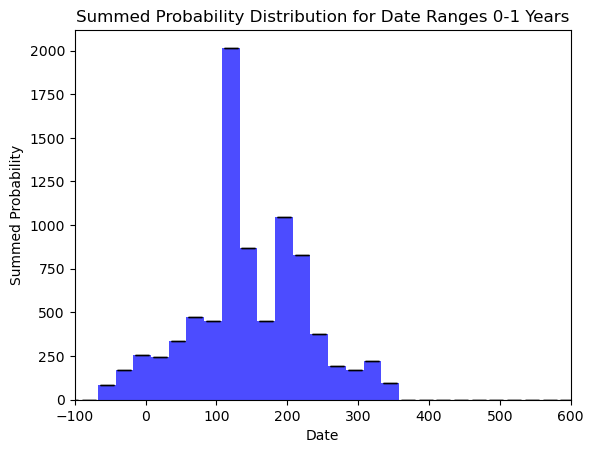

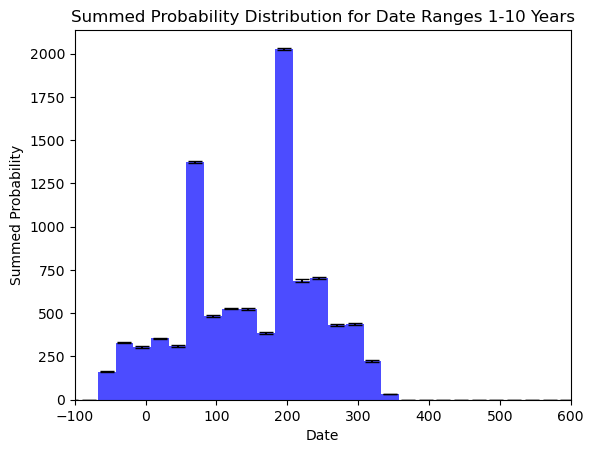

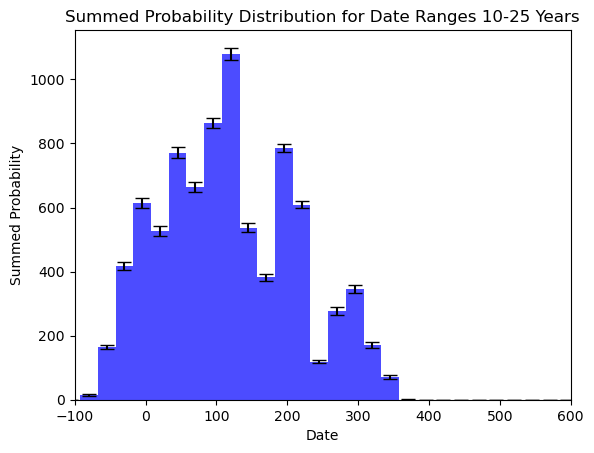

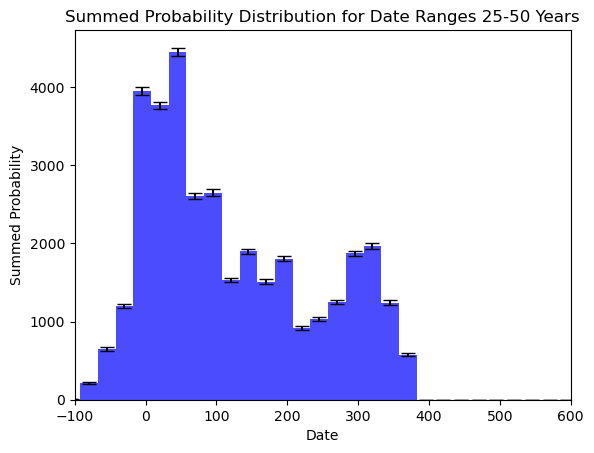

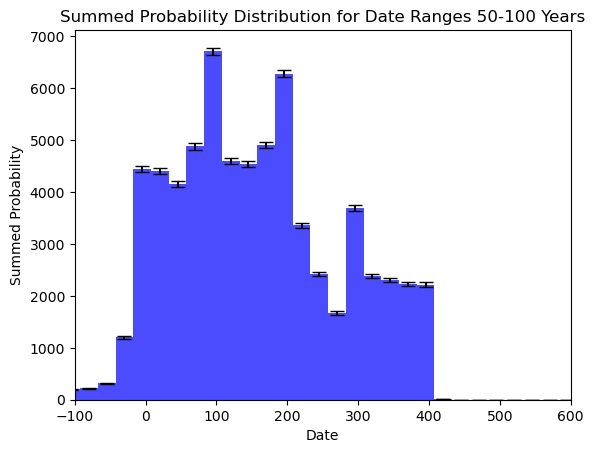

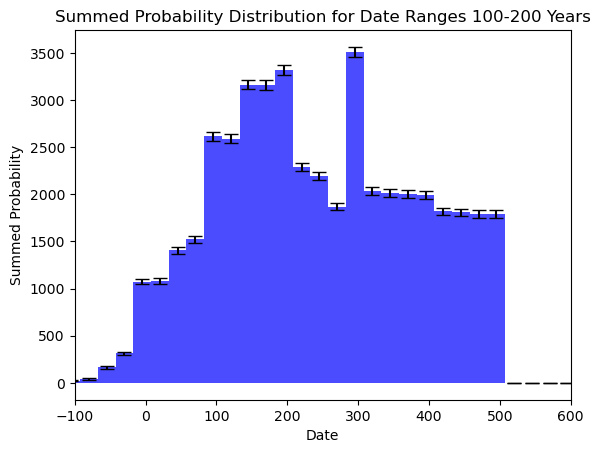

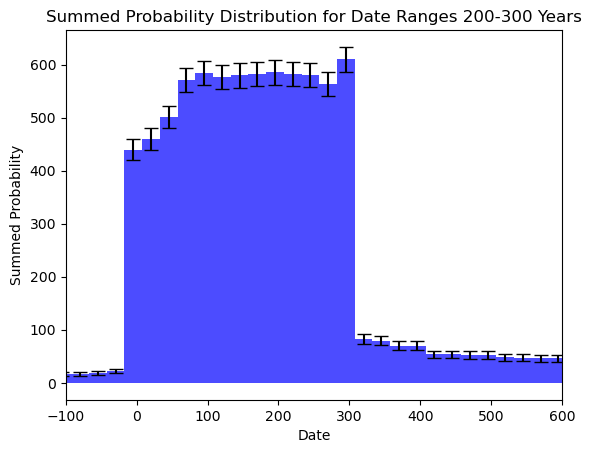

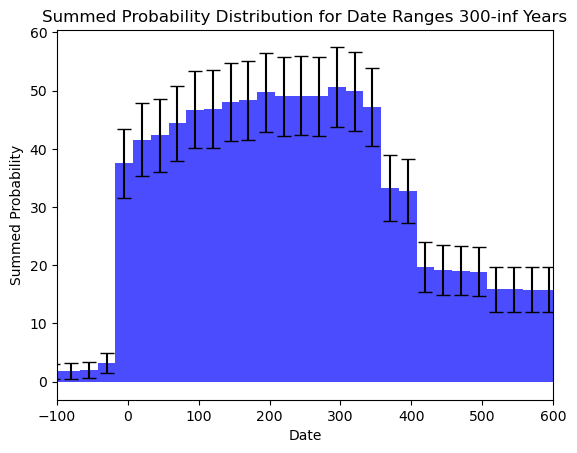

In [59]:
# Define your thresholds for date ranges
thresholds = [(0, 1), (1, 10), (10, 25), (25, 50), (50, 100), (100, 200), (200, 300), (300, float('inf'))]

# Determine the earliest and latest possible dates
earliest_date = int(lire['not_before'].min())
latest_date = int(lire['not_after'].max())

# Loop through each threshold and plot the corresponding summed probability
for start, end in thresholds:
    # Filter the data to only include rows within the current threshold
    subset_df = lire[(lire['date_range'] >= start) & (lire['date_range'] < end)]
    
    # Calculate the summed probability and standard deviations for the filtered data
    summed_prob, std_devs = compute_summed_probability(subset_df, earliest_date, latest_date, resolution=25)
    
    # Generate x-values for plotting, making sure they align in shape with summed_prob
    x_values = np.arange(earliest_date, latest_date, 25)[:len(summed_prob)]
    
    # Create a new figure for the plot
    plt.figure()
    
    # Set the title and labels
    plt.title(f'Summed Probability Distribution for Date Ranges {start}-{end} Years')
    plt.xlabel('Date')
    plt.xlim([-100, 600])
    plt.ylabel('Summed Probability')
    
    # Create the bar chart with error bars
    plt.bar(x_values, summed_prob, yerr=std_devs, width=25, color='blue', alpha=0.7, capsize=5)
    
    # Show the plot
    plt.show()


## SPA plots *under* various thresholds with error margins

### Compute summed probability and error

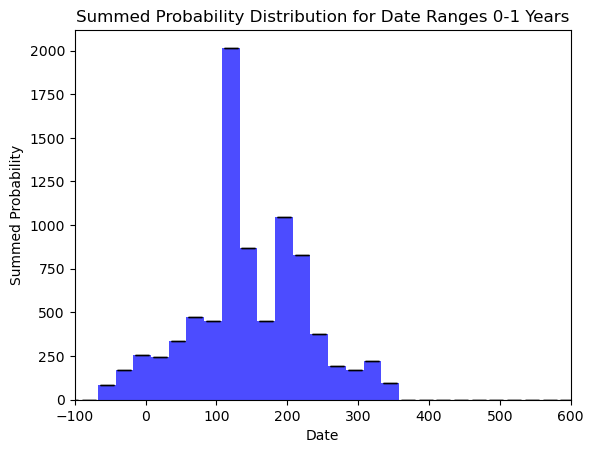

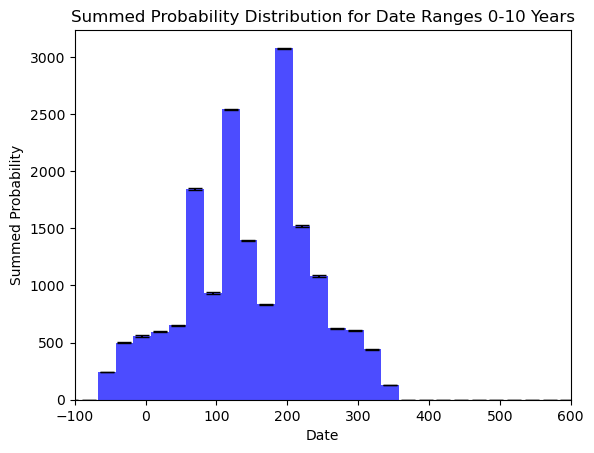

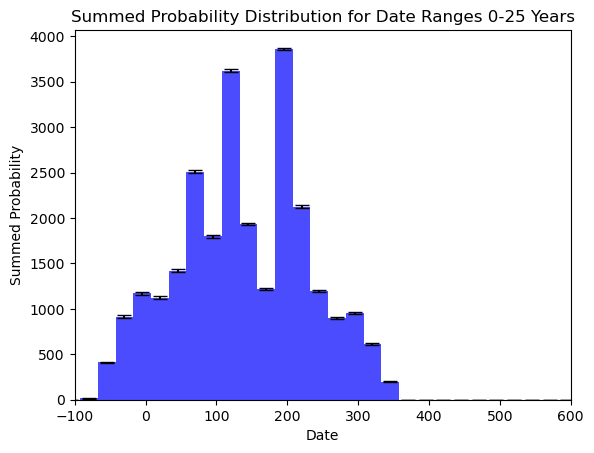

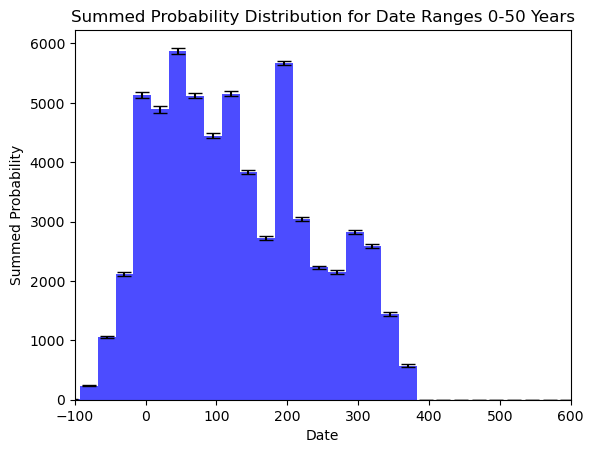

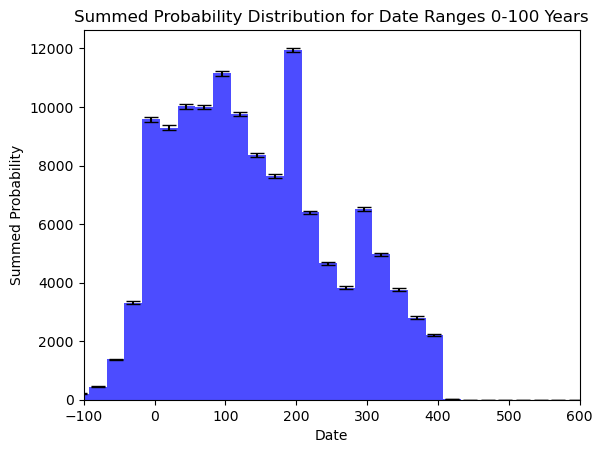

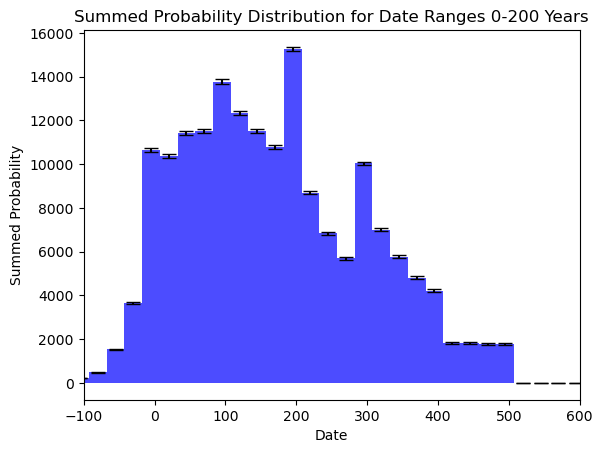

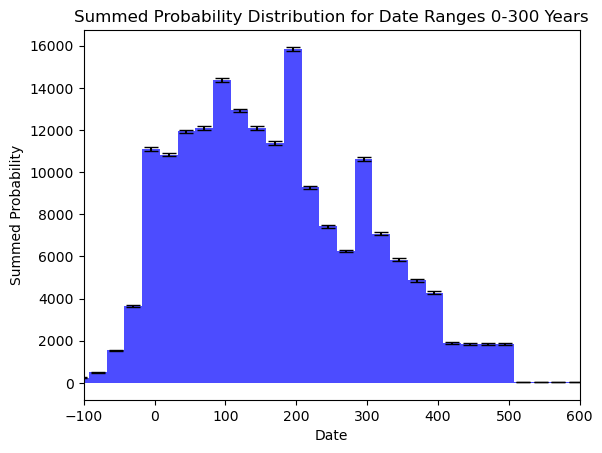

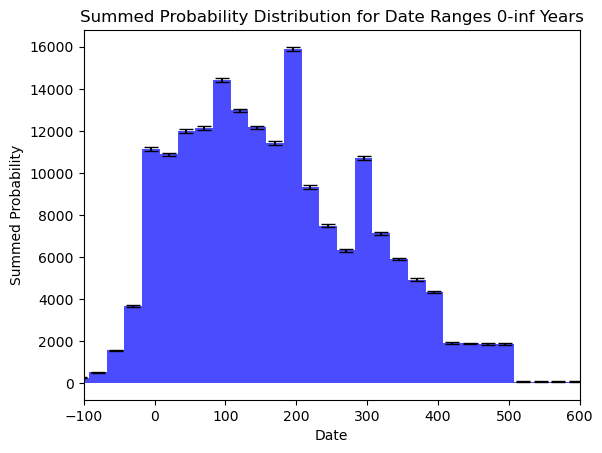

In [60]:
# Define your thresholds for date ranges
thresholds = [(0, 1), (0, 10), (0, 25), (0, 50), (0, 100), (0, 200), (0, 300), (0, float('inf'))]

# Determine the earliest and latest possible dates
earliest_date = int(lire['not_before'].min())
latest_date = int(lire['not_after'].max())

# Loop through each threshold and plot the corresponding summed probability
for start, end in thresholds:
    # Filter the data to only include rows within the current threshold
    subset_df = lire[(lire['date_range'] >= start) & (lire['date_range'] < end)]
    
    # Calculate the summed probability and standard deviations for the filtered data
    summed_prob, std_devs = compute_summed_probability(subset_df, earliest_date, latest_date, resolution=25)
    
    # Generate x-values for plotting, making sure they align in shape with summed_prob
    x_values = np.arange(earliest_date, latest_date, 25)[:len(summed_prob)]
    
    # Create a new figure for the plot
    plt.figure()
    
    # Set the title and labels
    plt.title(f'Summed Probability Distribution for Date Ranges {start}-{end} Years')
    plt.xlabel('Date')
    plt.xlim([-100, 600])
    plt.ylabel('Summed Probability')
    
    # Create the bar chart with error bars
    plt.bar(x_values, summed_prob, yerr=std_devs, width=25, color='blue', alpha=0.7, capsize=5)
    
    # Show the plot
    plt.show()


## SPA plots *under* various thresholds with trend line and error margins

### Compute and plot summed probability, trend line points, and error margins

#### Full dataset

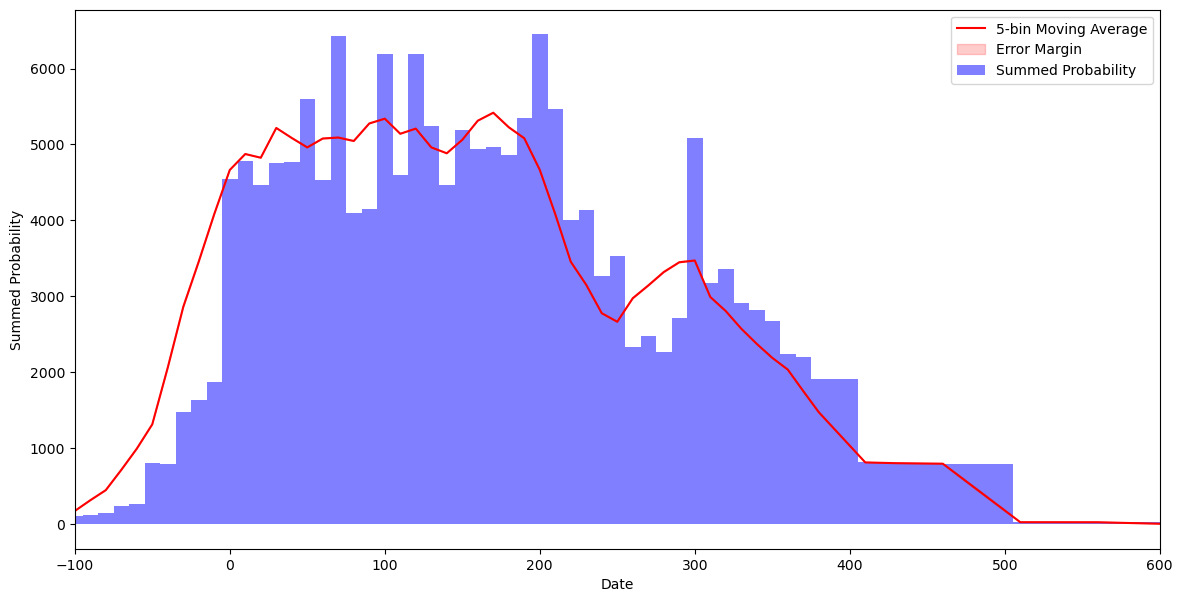

In [75]:
def moving_average(data, window_size):
    """Calculate the moving average of a 1D array."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def moving_std(data, window_size):
    """Calculate the moving standard deviation of a 1D array."""
    return np.array([np.std(data[i:i+window_size]) for i in range(len(data) - window_size + 1)])

# Data preparation
earliest_date = int(lire['not_before'].min())
latest_date = int(lire['not_after'].max())

# Choose your bin resolution and window size for moving average
resolution = 10 # Bin resolution
window_size = 5 # Number of bins being averaged; multiply by resolution to get the moving average in years

# Compute summed probability and standard deviations
summed_prob, std_devs = compute_summed_probability(lire, earliest_date, latest_date, resolution=resolution)

# Generate x-values for plotting
x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]

# Calculate the moving average and moving standard deviation
avg_moving = moving_average(summed_prob, window_size)
std_moving = moving_std(std_devs, window_size)

# Generate x-values for the moving average (it will be shorter due to the window size)
x_moving = x_values[:len(avg_moving)]

# Plotting
plt.figure(figsize=(14, 7))
plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
plt.plot(x_moving, avg_moving, color='red', label=f'{window_size}-bin Moving Average')
plt.fill_between(x_moving, avg_moving-std_moving, avg_moving+std_moving, color='red', alpha=0.2, label='Error Margin')
plt.xlabel('Date')
plt.xlim([-100, 600])
plt.ylabel('Summed Probability')
plt.legend()
plt.show()


#### *Between* various thresholds

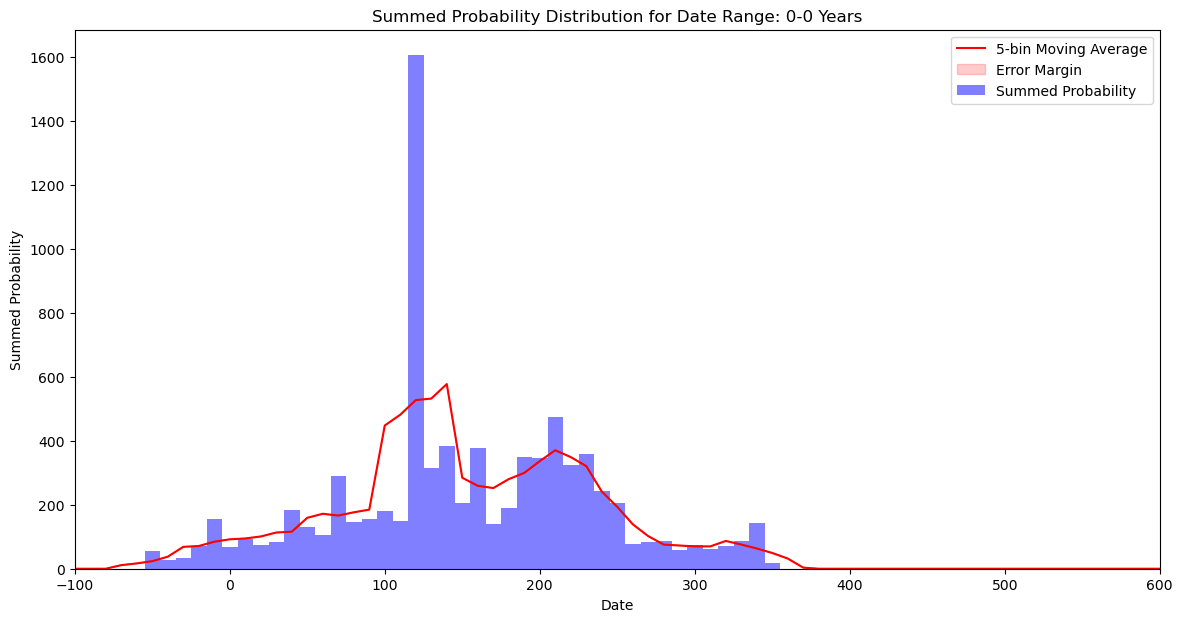

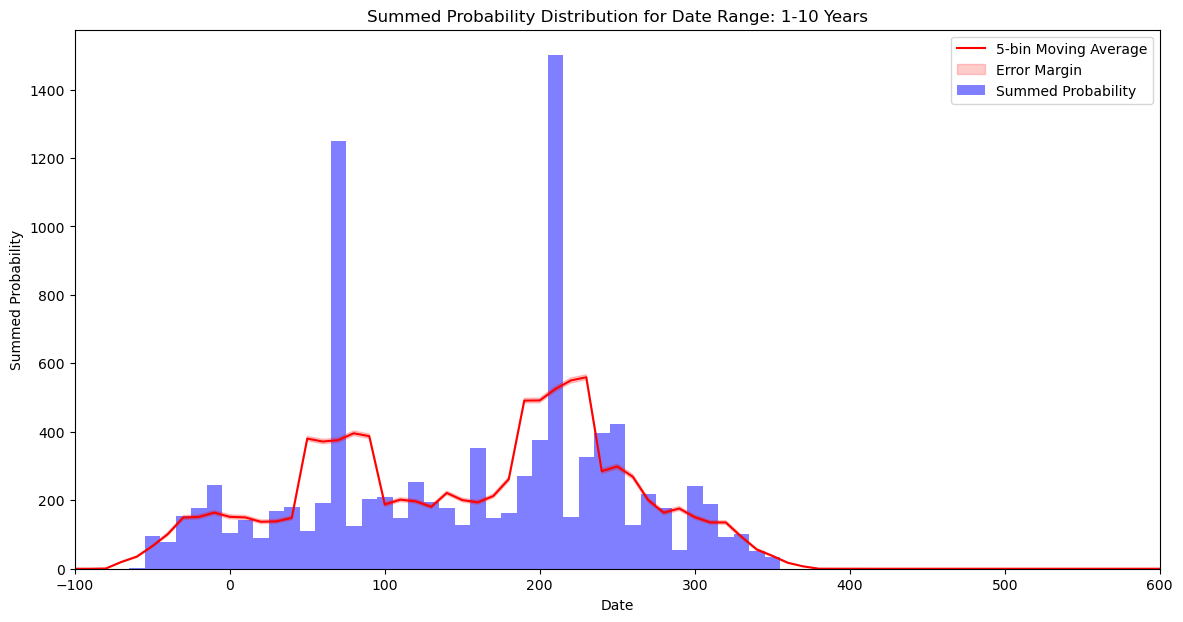

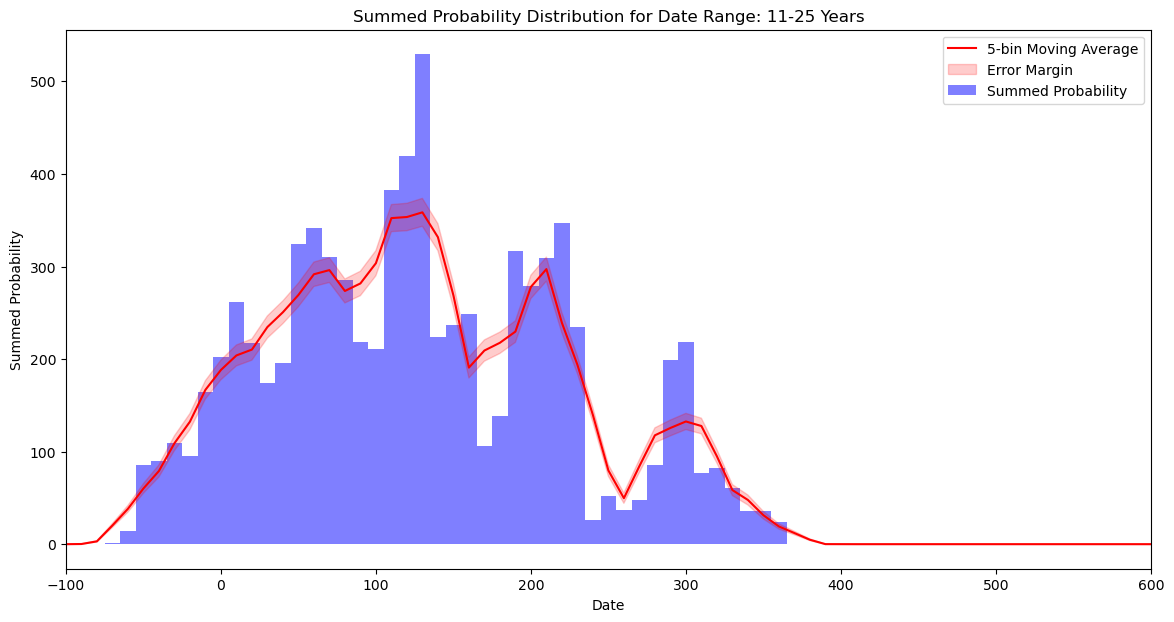

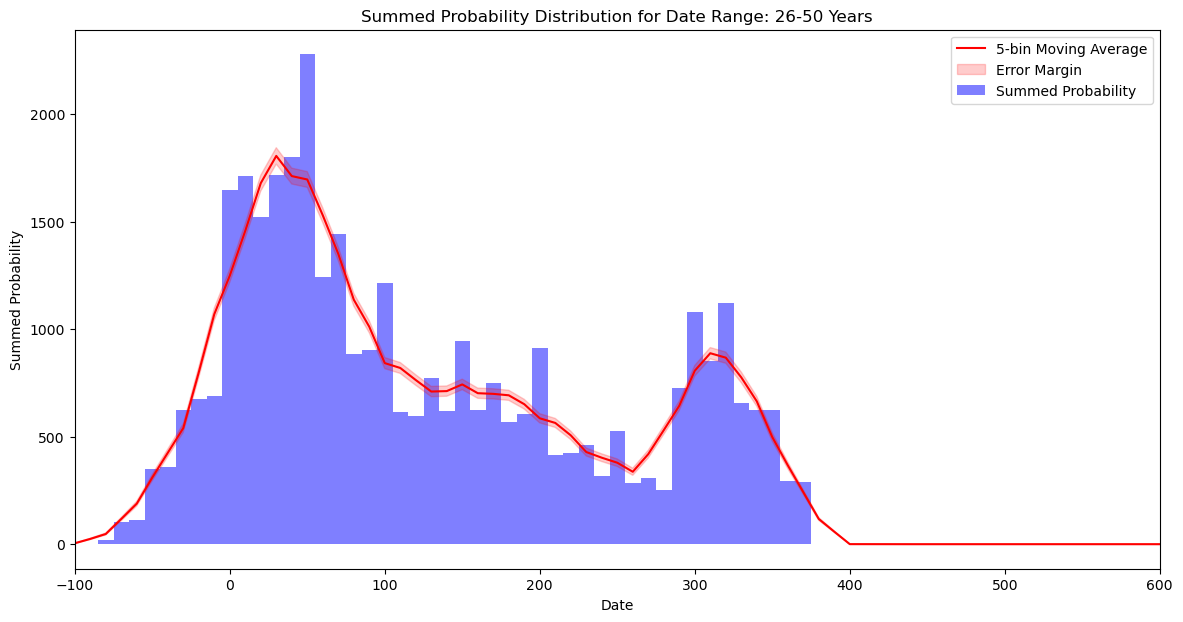

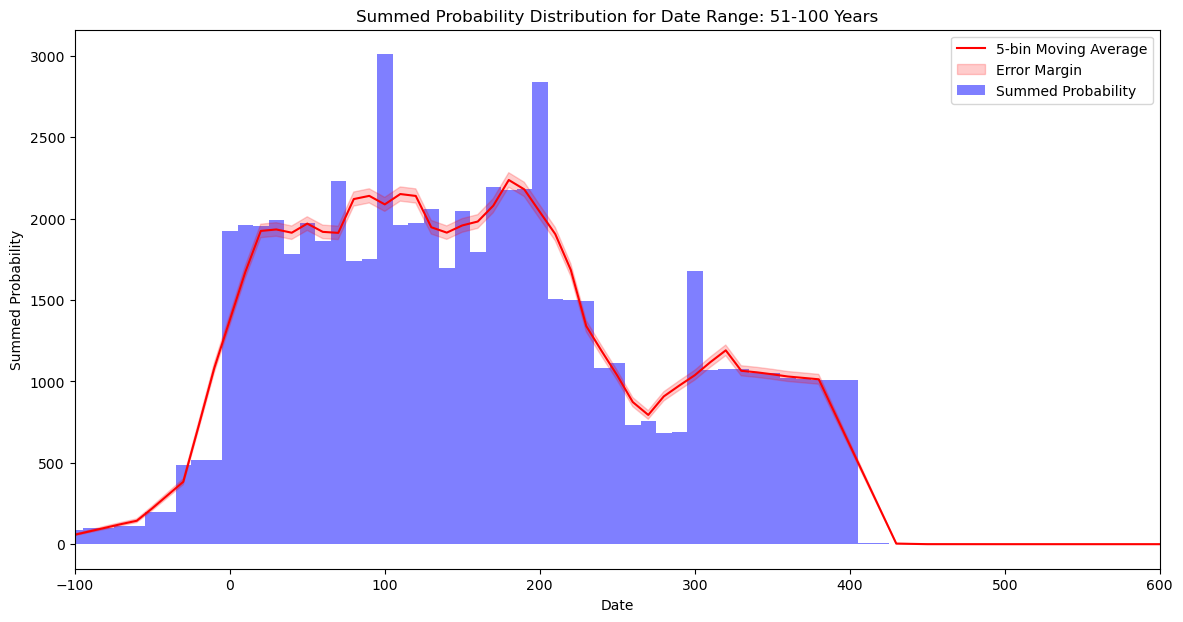

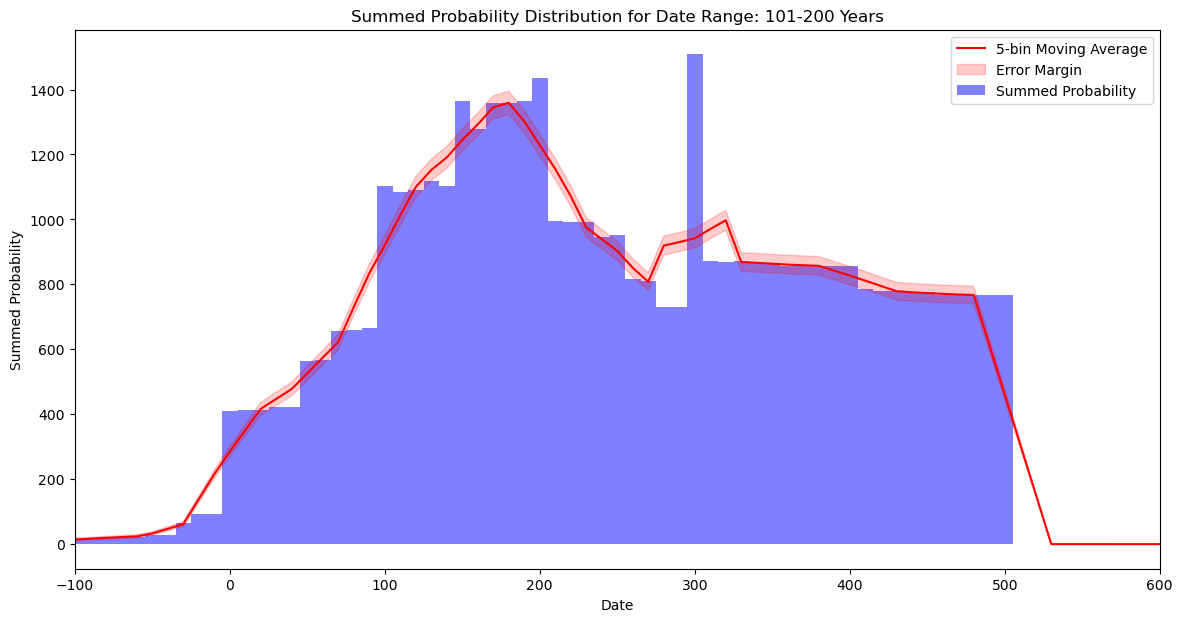

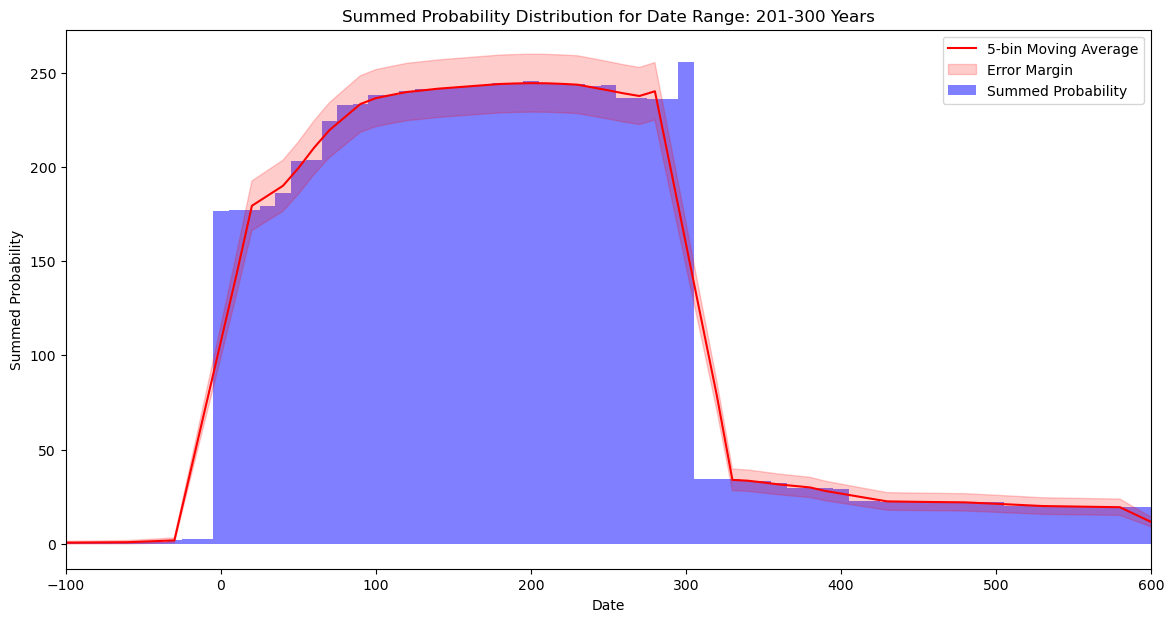

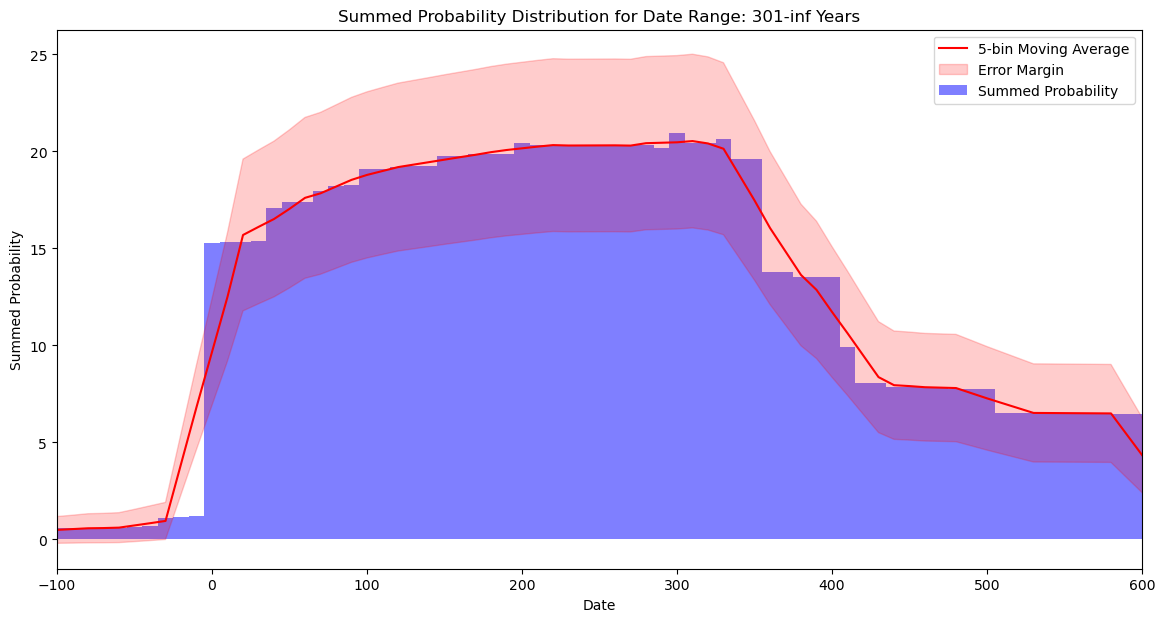

In [97]:
def compute_summed_probability(df, earliest_date, latest_date, resolution=10):
    """
    Compute the summed probability distribution of inscriptions with error margins.
    
    Parameters:
    - df: DataFrame containing the date ranges
    - earliest_date, latest_date: the date limits for the distribution
    - resolution: bin size for the histogram (in years)
    
    Returns:
    - summed_prob: summed probability distribution
    - std_devs: standard deviations for each bin
    """
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    for _, row in df.iterrows():
        start_date = row['not_before']
        end_date = row['not_after']
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Avoid negative or out-of-bounds indices
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for the given date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
            
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

# Define date range thresholds for filtering
thresholds = [(0, 0), (1, 10), (11, 25), (26, 50), (51, 100), (101, 200), (201, 300), (301, float('inf'))]

# Define overall earliest and latest date in the dataset, and bin resolution
earliest_date, latest_date = lire['not_before'].min(), lire['not_after'].max()
resolution = 10

# Loop through each date range and plot
for start, end in thresholds:
    if end == float('inf'):
        subset_df = lire[lire['date_range'] >= start]
        label = f"{start}+"
    elif start == 0 and end == 0:
        subset_df = lire[lire['date_range'] == 0]
        label = f"{start}"
    else:
        subset_df = lire[(lire['date_range'] >= start) & (lire['date_range'] <= end)]
        label = f"{start}-{end - 1}"
    
    # Calculate the summed probability and standard deviations for the filtered data
    summed_prob, std_devs = compute_summed_probability(subset_df, earliest_date, latest_date, resolution=10)
    
    # Generate x-values for plotting, making sure they align in shape with summed_prob
    x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]
    
    plt.figure(figsize=(14, 7))
    
    # Plot the summed probability distribution
    plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
    
   # Calculate and plot the moving average
    window_size = 5
    moving_avg = np.convolve(summed_prob, np.ones(window_size)/window_size, mode='valid')

    # Calculate and plot the error margins
    moving_std_dev = np.convolve(std_devs, np.ones(window_size)/window_size, mode='valid')

    # Make sure moving_avg and moving_std_dev have the same length
    if len(moving_avg) != len(moving_std_dev):
        min_len = min(len(moving_avg), len(moving_std_dev))
        moving_avg = moving_avg[:min_len]
        moving_std_dev = moving_std_dev[:min_len]

    # Generate x-values for the moving average and error margins
    moving_avg_x = x_values[int(window_size/2):-int(window_size/2)+1][:len(moving_avg)]
    
    # Plot the moving average
    plt.plot(moving_avg_x, moving_avg, color='red', label=f"{window_size}-bin Moving Average")
    plt.fill_between(moving_avg_x, moving_avg - moving_std_dev, moving_avg + moving_std_dev, color='red', alpha=0.2, label='Error Margin')  # Added label here
    plt.title(f"Summed Probability Distribution for Date Range: {start}-{end} Years")

    plt.xlabel('Date')
    plt.xlim([-100, 600])
    plt.ylabel('Summed Probability')
    plt.legend()
    
    plt.show()


#### *Under* various thresholds

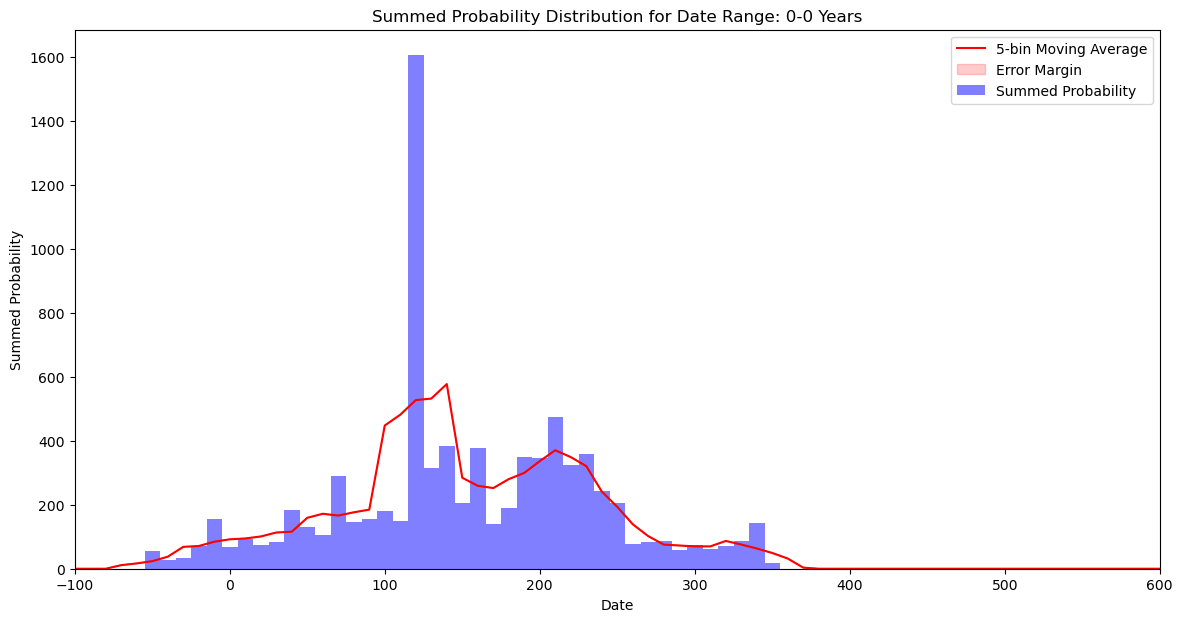

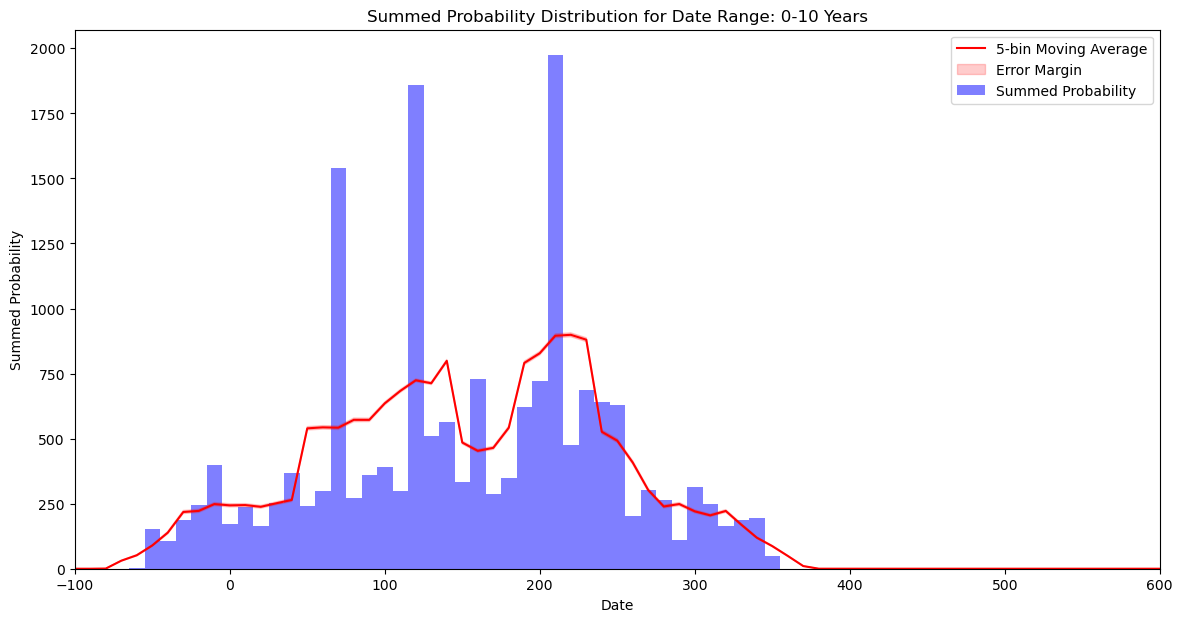

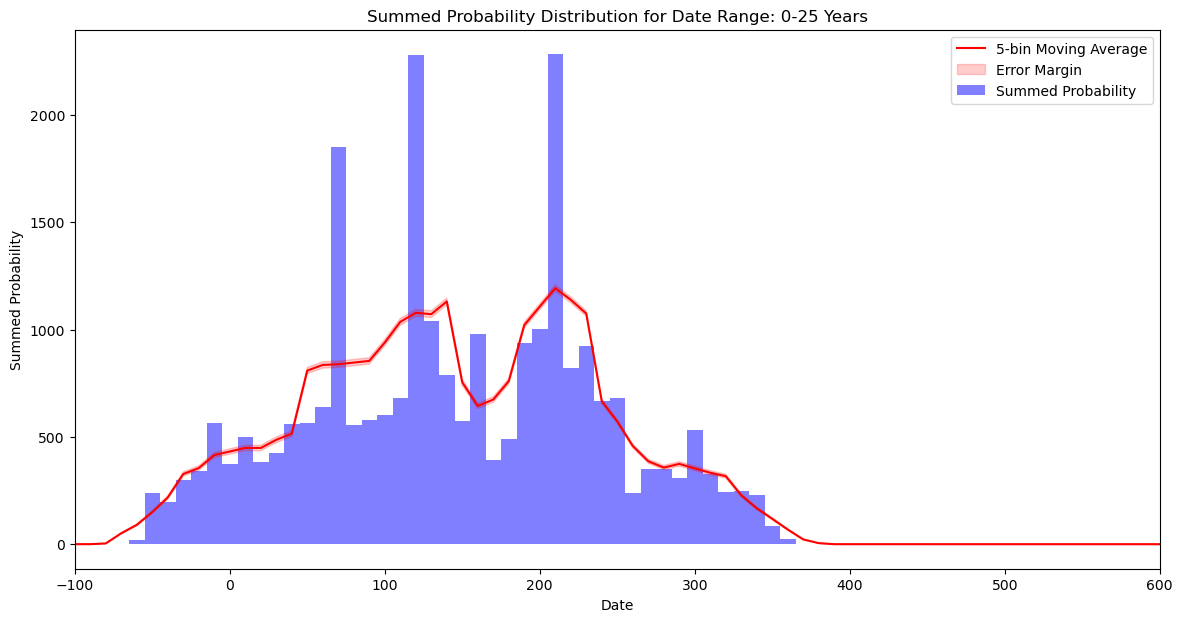

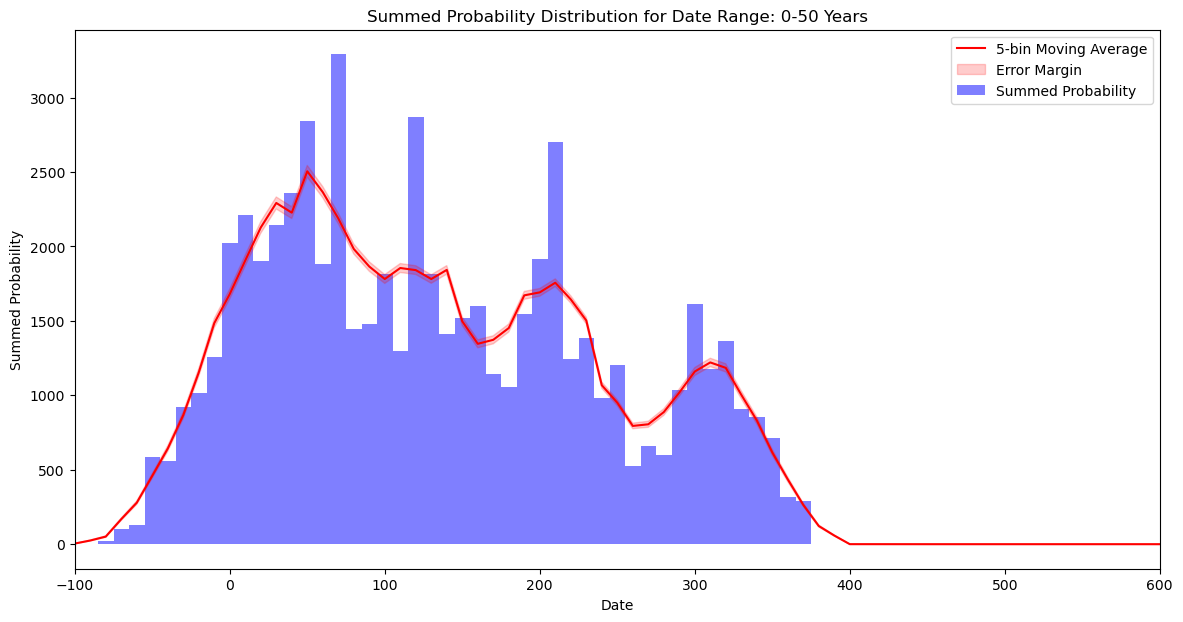

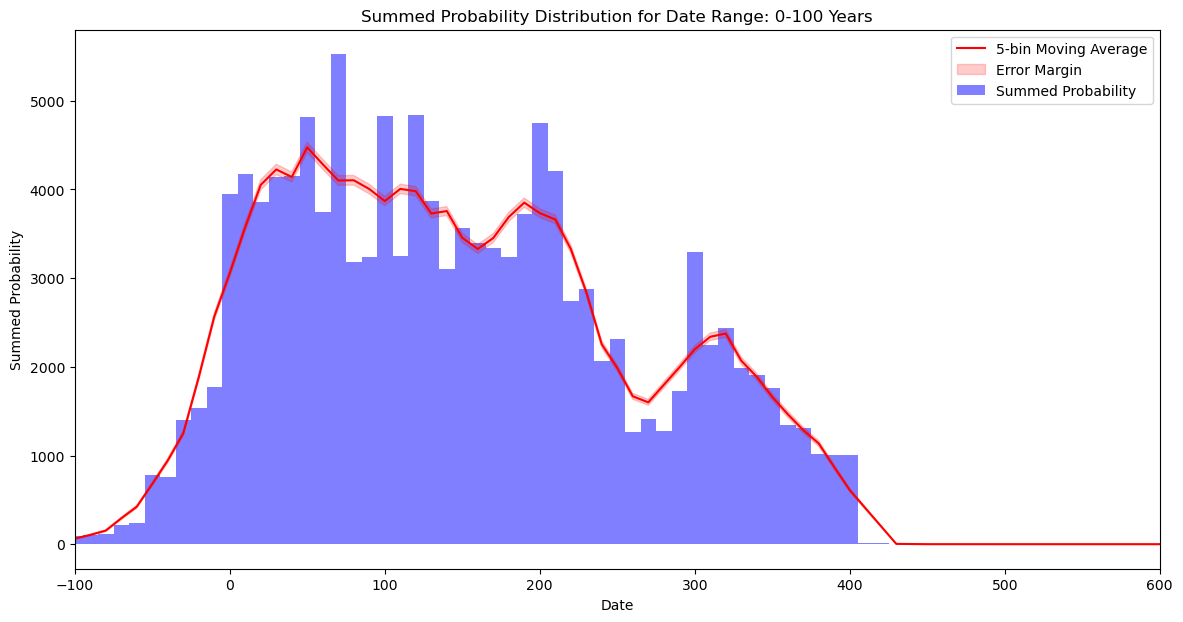

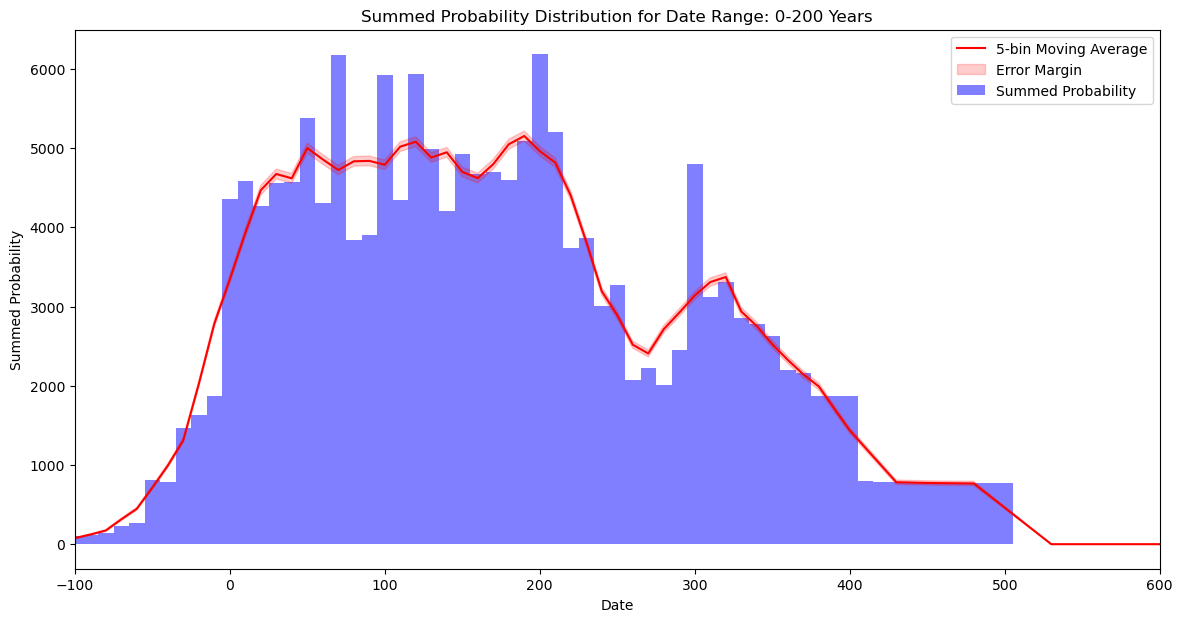

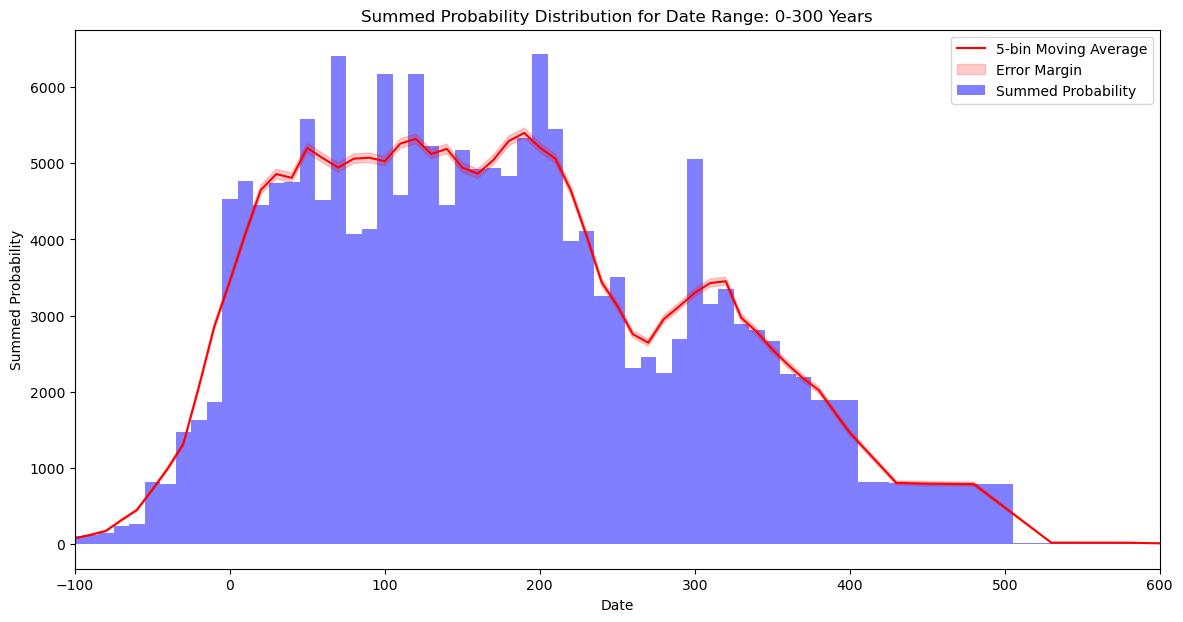

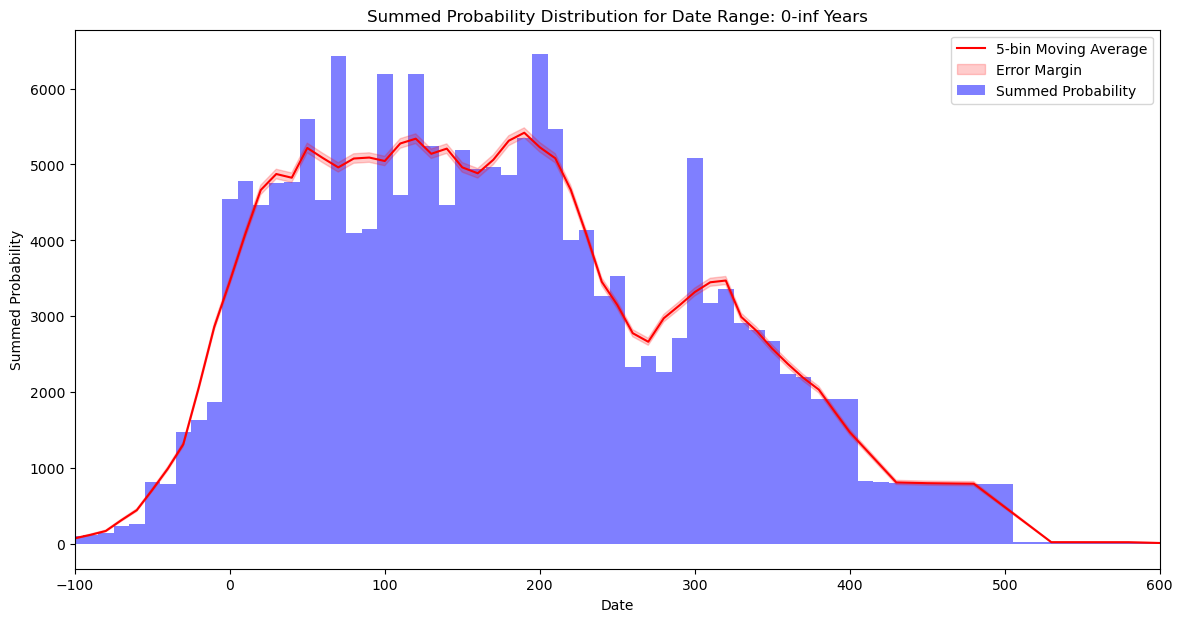

In [99]:
def compute_summed_probability(df, earliest_date, latest_date, resolution=10):
    """
    Compute the summed probability distribution of inscriptions with error margins.
    
    Parameters:
    - df: DataFrame containing the date ranges
    - earliest_date, latest_date: the date limits for the distribution
    - resolution: bin size for the histogram (in years)
    
    Returns:
    - summed_prob: summed probability distribution
    - std_devs: standard deviations for each bin
    """
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    for _, row in df.iterrows():
        start_date = row['not_before']
        end_date = row['not_after']
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Avoid negative or out-of-bounds indices
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for the given date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
            
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

# Define date range thresholds for filtering
thresholds = [(0, 0), (0, 10), (0, 25), (0, 50), (0, 100), (0, 200), (0, 300), (0, float('inf'))]

# Define overall earliest and latest date in the dataset, and bin resolution
earliest_date, latest_date = lire['not_before'].min(), lire['not_after'].max()
resolution = 10

# Loop through each date range and plot
for start, end in thresholds:
    if end == float('inf'):
        subset_df = lire[lire['date_range'] >= start]
        label = f"{start}+"
    elif start == 0 and end == 0:
        subset_df = lire[lire['date_range'] == 0]
        label = f"{start}"
    else:
        subset_df = lire[(lire['date_range'] >= start) & (lire['date_range'] <= end)]
        label = f"{start}-{end - 1}"
    
    # Calculate the summed probability and standard deviations for the filtered data
    summed_prob, std_devs = compute_summed_probability(subset_df, earliest_date, latest_date, resolution=10)
    
    # Generate x-values for plotting, making sure they align in shape with summed_prob
    x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]
    
    plt.figure(figsize=(14, 7))
    
    # Plot the summed probability distribution
    plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
    
   # Calculate and plot the moving average
    window_size = 5
    moving_avg = np.convolve(summed_prob, np.ones(window_size)/window_size, mode='valid')

    # Calculate and plot the error margins
    moving_std_dev = np.convolve(std_devs, np.ones(window_size)/window_size, mode='valid')

    # Make sure moving_avg and moving_std_dev have the same length
    if len(moving_avg) != len(moving_std_dev):
        min_len = min(len(moving_avg), len(moving_std_dev))
        moving_avg = moving_avg[:min_len]
        moving_std_dev = moving_std_dev[:min_len]

    # Generate x-values for the moving average and error margins
    moving_avg_x = x_values[int(window_size/2):-int(window_size/2)+1][:len(moving_avg)]
    
    # Plot the moving average
    plt.plot(moving_avg_x, moving_avg, color='red', label=f"{window_size}-bin Moving Average")
    plt.fill_between(moving_avg_x, moving_avg - moving_std_dev, moving_avg + moving_std_dev, color='red', alpha=0.2, label='Error Margin')  # Added label here
    plt.title(f"Summed Probability Distribution for Date Range: {start}-{end} Years")

    plt.xlabel('Date')
    plt.xlim([-100, 600])
    plt.ylabel('Summed Probability')
    plt.legend()
    
    plt.show()
